In [1]:
import pandas as pd
import requests
import urllib3
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from pandas.api.types import CategoricalDtype

pd.options.mode.chained_assignment = None  # default='warn'
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)


In [2]:
auth_url = "https://www.strava.com/oauth/token"
activites_url = "https://www.strava.com/api/v3/athlete/activities"
single_act_url = "https://www.strava.com/api/v3/activities"

###These are the things that are unique to each user/athlete
#I followed this tutorial: https://towardsdatascience.com/using-the-strava-api-and-pandas-to-explore-your-activity-data-d94901d9bfde
#But the Strava one is probably about as good:https://developers.strava.com/docs/getting-started/
clientID = "73092"
client_secret = "7ce9c1a9ef12c146f5e3e25bc5761e2d7c6e7009"
code = "52ec5853b048a139d88b4754b2783c7753c9c1e8"
refresh_tok = "24507a9c490400cc0f281775ba0ee7b1db1d2677"
access_tok = "ccb217b4c599b9a15b6550cbd1d2bca2986c937a" #I used this as a placeholder -- these expire

payload = {
    'client_id': clientID,
    'client_secret': client_secret,
    'refresh_token': refresh_tok,
    'grant_type': "refresh_token",
    'f': 'json'
}

#API call to get an updated access_token, saves it in correct format (expires ~6hr?)
res = requests.post(auth_url, data=payload, verify=False)
access_token = res.json()['access_token']

#Sets up and performs API calls to get activities, max is 200 items/page, I needed 15 pages, but fine to overshoot
header = {'Authorization': 'Bearer ' + access_token}

#First call (first 200 acts)
param = {'per_page': 200, 'page': 1}
my_dataset = requests.get(activites_url, headers=header, params=param).json()
allAct = pd.json_normalize(my_dataset)

#Then get the rest. Yes, this could be cleaner.
for i in range (2,20):      #The 20 here is overkill for most, can be tuned down
    param = {'per_page': 200, 'page': i}
    new_data = requests.get(activites_url, headers=header, params=param).json()
    allAct = allAct.append(pd.json_normalize(new_data))

#This function gets a single activity's data
def getActivity(actID):
    header = {'Authorization': 'Bearer ' + access_token}
    param = {'per_page': 200, 'page': 1}
    activity = requests.get(single_act_url+'/'+str(actID)+'/streams?keys=time,distance,heartrate,cadence,watts,temp&key_by_type=true', headers=header).json()
    #print(activity)
    activityPD = pd.json_normalize(activity)
    return activityPD

# How to get a single activities data. I don't do anything with it on this file.
singleAct = getActivity(6088673215)
singleAct.head()

allAct.to_csv(("allactivities.csv"))

##Once I got 'em, might as well not do the API call
allAct = pd.read_csv("allactivities.csv")

In [3]:
## Example of how to reduce the number of columns
# cols = ['name','id', 'upload_id', 'type', 'distance', 'moving_time',   
#          'average_speed', 'average_heartrate','max_speed','average_watts',
#          'weighted_average_watts', 'kilojoules','total_elevation_gain',
#          'start_date_local','average_temp','gear_id','map.summary_polyline','commute',
#          'workout_type'
#        ]

#How to reduce it -- I'm not here
act = allAct  #--[cols]

#Adding/adjust date/time options
act['start_date_local2'] = pd.to_datetime(act['start_date_local'])
act['start_time'] = act['start_date_local2'].dt.time    #Splitting out time and date into separate columns
act['start_date_local2'] = act['start_date_local2'].dt.date
act['days_in'] = act['start_date_local2']-act.loc[len(act)-1,'start_date_local2']
act['days_in'] = act['days_in'].dt.days.astype(float)       #Allowing me to heatmap by recency
act

,Unnamed: 0,resource_state,name,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,workout_type,...,athlete.resource_state,map.id,map.summary_polyline,map.resource_state,average_temp,elev_high,elev_low,start_date_local2,start_time,days_in
0,0,2,Free Ride 60,34028.9,3600,3600,0.0,Ride,Ride,12.0,...,1,a8374361933,NaN,2,NaN,NaN,NaN,2023-01-11,05:06:23,3094.0
1,1,2,Morning Weight Training,0.0,3549,3549,0.0,WeightTraining,WeightTraining,NaN,...,1,a8360151930,NaN,2,NaN,NaN,NaN,2023-01-08,10:34:11,3091.0
2,2,2,Post (?) COVID checkin,33005.1,3600,3600,0.0,Ride,Ride,12.0,...,1,a8355073222,NaN,2,NaN,NaN,NaN,2023-01-07,13:43:18,3090.0
3,3,2,Free Ride 90,34727.2,3786,3786,0.0,Ride,Ride,12.0,...,1,a8327956677,NaN,2,NaN,NaN,NaN,2023-01-02,12:07:44,3085.0
4,4,2,Garrowby +2,52386.7,5400,5400,0.0,Ride,Ride,12.0,...,1,a8318125585,NaN,2,NaN,NaN,NaN,2022-12-31,11:45:40,3083.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2994,194,2,Morning Ride,28869.0,4562,4664,265.3,Ride,Ride,NaN,...,1,a172508236,ajljG~felL}@nByIHgNzHcZyAi_ApQsXfP`@pRcl@hq@wI...,2,NaN,161.1,52.4,2014-07-29,09:10:32,6.0
2995,195,2,Boulevard double,11565.3,3103,3327,37.5,Run,Run,3.0,...,1,a172055880,seoiGx|zkLdBmG}BaHcGyIyGGmB}IqC}BsU{EyOiJmTVmA...,2,NaN,13.3,-0.6,2014-07-28,08:36:08,5.0
2996,196,2,Hampton,6543.8,1723,1874,0.0,Run,Run,0.0,...,1,a171210205,kahyFlaiwLoBc@|FaIhN{f@ca@cHkOjKiIx@sc@{JkCnGi...,2,NaN,9.1,-0.2,2014-07-26,13:00:36,3.0
2997,197,2,Afternoon Ride,29467.5,4310,4730,254.7,Ride,Ride,NaN,...,1,a170023397,ohwhFzv{{M_f@|`CaY~`@`E`YyKd\B|L|AlGeC|OiF|@mB...,2,NaN,215.7,111.8,2014-07-23,16:20:30,0.0


elevation_per_mile
(0.0, 20.0]        78
(20.0, 40.0]      312
(40.0, 60.0]      309
(60.0, 80.0]      231
(80.0, 101.0]      75
(101.0, 121.0]     22
(121.0, 141.0]      8
Name: elevation_per_mile, dtype: int64

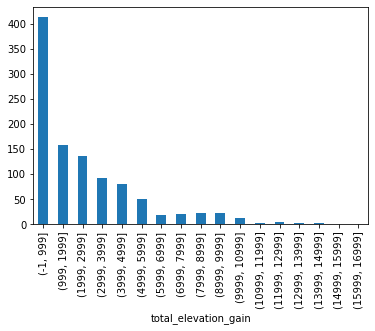

In [4]:
#Stuff in this cell is just me playing with different groupings/visuals

#activities['type'].value_counts().plot(kind = 'bar')

#Using bins to divide up rides and visualize
ridesOnly = act.loc[act['type'] == 'Ride']
ridesOnly.total_elevation_gain = ridesOnly.total_elevation_gain*(3.28084)
ridesOnlyOut = ridesOnly.loc[ridesOnly['total_elevation_gain'] > 100]
binning = np.arange(-1,17999,1000)
bins = binning.tolist()
ridesByElevation = ridesOnlyOut.groupby(pd.cut(ridesOnlyOut.total_elevation_gain,bins))
ridesByElevation['total_elevation_gain'].count().plot(kind = 'bar')

#Okay, that works, now lets do elevation per mile
ridesOnlyOut['elevation_per_mile'] = ridesOnlyOut['total_elevation_gain']/(ridesOnlyOut['distance']*0.000621371)
mx = ridesOnlyOut['elevation_per_mile'].max()
ebinning = np.arange(0,mx,mx/8.).round()
ebins = ebinning.tolist()
ridesByClimbing = ridesOnlyOut.groupby(pd.cut(ridesOnlyOut.elevation_per_mile,ebins))
ridesByClimbing['elevation_per_mile'].count()#.plot(kind = 'bar')
#view = ridesOnlyOut.loc[ridesOnlyOut['elevation_per_mile']>120]
#view.head(20)

In [5]:
#Filtering down to just rides
selActs = act.loc[act['type'] == 'Ride']
#Filtering down to just rides with power data (I don't think estimated power appears here)
selActs = selActs[selActs['weighted_average_watts'] > 0] 
#Knocks out commutes
selActs = selActs[selActs['commute']==False] 

##Playing with plotting
#sns.set(style="ticks", context="talk")
#sns.regplot(x='moving_time', y = 'weighted_average_watts', data = selActs).set_title("Power vs. Time")

/var/folders/hk/8yhk12y94z7fwn097_d9fzjh0000gp/T/ipykernel_14546/3358329848.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


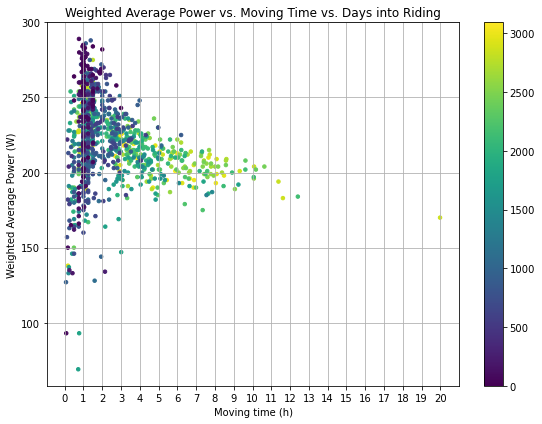

In [6]:
# A probably quite messily set up figure/plot

fig = plt.figure(figsize=(8,6)) #create overall container
ax1 = fig.add_subplot(111) #add a 1 by 1 plot to the figure

days_range = selActs.loc[0,'days_in']

xval = 'moving_time'
yval = 'weighted_average_watts'
x = np.asarray(selActs[xval])  #convert data to numpy array
y = np.asarray(selActs[yval])
coloring = np.asarray(selActs['days_in'])

x = x/60/60 #unit conversion down to hours

ax1.scatter(x, y,c=coloring,cmap = 'viridis',label=coloring,s=12) #plot data points in scatter plot on ax1
xmin, xmax = ax1.get_xlim()

ax1.set_xticks(np.arange(0, np.round(xmax), 1)) 
ax1.grid()

ax1.set_title("Weighted Average Power vs. Moving Time vs. Days into Riding")
ax1.set_xlabel('Moving time (h)')
ax1.set_ylabel('Weighted Average Power (W)')

#This took me way longer than it should have to figure out...
norm = matplotlib.colors.Normalize(vmin=0, vmax=days_range, clip=False)
fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax1)

fig.tight_layout()
fig.show()

<AxesSubplot:xlabel='DayofWeekName', ylabel='DayHour'>

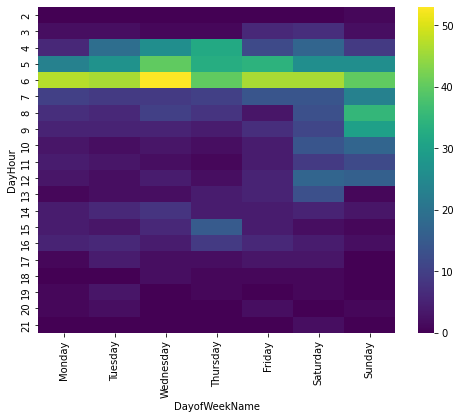

In [7]:
#Used to do the groupby below
def countRows(rows):
    return len(rows)

#Sets up columns for this graph
selActs['start_date_local'] = pd.to_datetime(selActs['start_date_local'],infer_datetime_format=True)#"%Y-%m-%dT%H:%M:%SZ")#+"%m/%d/%Y %H:%M:%S") #2021-10-13T10:44:34Z
selActs['DayofWeekNum'] = selActs['start_date_local'].dt.dayofweek
selActs['DayofWeekName'] = selActs['start_date_local'].dt.day_name()

#Allows for ordering by day of week
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_type = CategoricalDtype(categories=cats, ordered=True)
selActs['DayofWeekName'] = selActs['DayofWeekName'].astype(cat_type)
selActs['DayHour'] = selActs['start_date_local'].dt.hour
selActs['DayNum'] = selActs['start_date_local'].dt.dayofyear

#The groupby
by_hour_weekday = selActs.groupby('DayHour DayofWeekName'.split()).apply(countRows).unstack()
by_hour_weekday = by_hour_weekday.fillna(0) #Otherwise there are white spots when no rides -- yuck

plt.figure(figsize = (8,6))
sns.heatmap(by_hour_weekday,cmap = 'viridis')